##### Silver Speech and Golden Silnce: Spoiler Detection Project

## Exploratory Data Analysis

In our EDA, we address the following questions: 
* Are different genres more likely to be spoilered?
* Are different books more likely to be spoilered?
* Are different reviewers more likely to write spoilers?
* What's the ratio of spoiler text/total review text in reviews? 
* Are spoilers at a particular position in the review?

In [4]:
#Imports
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import stats
from tqdm import tqdm

In [5]:
#Disable scientific notation for floats
pd.options.display.float_format = '{:,}'.format

#Enable viewing more (in this case: all) features of a dataset
pd.set_option('display.max_columns', 500)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#### Load data

In [6]:
train = pd.read_json('/Users/juliaschafer/NF_Capstone_Spoiler_Detection/data/train_data.json')

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 964616 entries, 0 to 964622
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              964616 non-null  object 
 1   time                 964616 non-null  int64  
 2   review               964616 non-null  object 
 3   rating               964616 non-null  int64  
 4   spoiler              964616 non-null  bool   
 5   book_id              964616 non-null  int64  
 6   review_id            964616 non-null  object 
 7   genres               964616 non-null  object 
 8   title                964616 non-null  object 
 9   description          959686 non-null  object 
 10  publication_year     869288 non-null  float64
 11  publication_month    851963 non-null  float64
 12  publication_day      833516 non-null  float64
 13  average_rating       964615 non-null  float64
 14  ratings_count        964615 non-null  float64
 15  num_pages        

In [8]:
train.head(2)

,user_id,time,review,rating,spoiler,book_id,review_id,genres,title,description,publication_year,publication_month,publication_day,average_rating,ratings_count,num_pages,weighted_avg_rating,genre,spoiler_dum,sentence_labels,review_texts,raw_text,review_len
0,28f8f1b5d8462df2dde271f0c4992bf3,1379548800000,"[[0, Harry Dresden is the best supernatural de...",5,False,7779059,41e678f5fa16cb717e0000ba833d423e,"{'fantasy, paranormal': 3499, 'fiction': 416, ...",Side Jobs: Stories from the Dresden Files (The...,"Here, together for the first time, are the sho...","2,010.0",10.0,26.0,4.24,"34,578.0",418.0,"146,610.72","fantasy, paranormal",0,"[0, 0, 0]",['Harry Dresden is the best supernatural detec...,Harry Dresden is the best supernatural detecti...,113
1,521496a9a29d60e3fa1d814041f1c62b,1491350400000,"[[0, Aww this was so much fun.], [0, I think I...",4,False,32066878,29443974b3bb5c63d8dab8871f76ece0,"{'romance': 251, 'young-adult': 6}","The Failing Hours (How to Date a Douchebag, #2)",Zeke Daniels isn't just a douchebag; he's an a...,"2,017.0",1.0,31.0,4.18,"3,959.0",322.0,"16,548.62",romance,0,"[0, 0]","['Aww this was so much fun.', 'I think I enjoy...",Aww this was so much fun I think I enjoyed the...,16


Unfortunately, the datatypes of some features haven't been stored correctly in the json file so the need to be changed once again. 

In [9]:
#Load time column as string
time = pd.read_csv('/Users/juliaschafer/NF_Capstone_Spoiler_Detection/data/time.csv')
time.drop('Unnamed: 0', axis = 1, inplace = True)

In [10]:
#Delete the 'old' time feature
train.drop('time', axis = 1, inplace = True)

In [11]:
#Concatenate datasets
train = pd.concat([train, time], axis = 1)

In [12]:
#Missing values after concatenation
train.isna().sum()

user_id                     7
review                      7
rating                      7
spoiler                     7
book_id                     7
review_id                   7
genres                      7
title                       7
description              4937
publication_year        95335
publication_month      112660
publication_day        131107
average_rating              8
ratings_count               8
num_pages               35788
weighted_avg_rating         8
genre                       8
spoiler_dum                 7
sentence_labels             7
review_texts                7
raw_text                    7
review_len                  7
time                       13
dtype: int64

In [13]:
#Drop supernumary rows
train.dropna(subset = ['review_len'], axis = 0, inplace = True)

In [14]:
#Change the data type of time from object to date in the format (YYYY-MM-DD)
from datetime import datetime
train.time = pd.to_datetime(train.time).dt.year

In [15]:
#Change the datatype of book_id to string
train.book_id = train.book_id.astype('str')

In [16]:
#Change datatype and labels for spoiler_dum
train.spoiler_dum = train.spoiler_dum.astype('category')

In [17]:
#Rename spoiler_dum categories
train.spoiler_dum = train.spoiler_dum.cat.rename_categories(['no spoiler', 'spoiler'])

### Overall descriptive statistics

In [18]:
#Descriptives of numeric features
train.select_dtypes('number').describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
rating,"964,616.0",3.69,1.25,0.0,3.0,4.0,5.0,5.0
publication_year,"869,288.0","2,011.12",5.56,"1,843.0","2,010.0","2,012.0","2,014.0","2,019.0"
publication_month,"851,963.0",6.29,3.26,1.0,4.0,6.0,9.0,12.0
publication_day,"833,516.0",14.02,9.81,1.0,5.0,13.0,24.0,31.0
average_rating,"964,615.0",4.0,0.27,2.08,3.83,4.02,4.19,4.82
ratings_count,"964,615.0","124,057.77","393,197.44",17.0,"4,180.0","16,379.0","69,923.0","4,899,965.0"
num_pages,"928,835.0",358.1,145.99,1.0,287.0,346.0,416.0,"6,680.0"
weighted_avg_rating,"964,615.0","509,601.34","1,647,392.69",65.96,"16,418.38","65,823.57","285,122.81","21,265,848.1"
review_len,"964,616.0",193.35,226.94,1.0,40.0,110.0,267.0,"3,278.0"
time,"964,603.0","2,014.49",2.04,"2,006.0","2,013.0","2,015.0","2,016.0","2,017.0"


In [19]:
#Descriptives of non-numerical variables
train[['genre', 'title', 'spoiler_dum']].describe().round(2).transpose()

,count,unique,top,freq
genre,964615,10,"fantasy, paranormal",321922
title,964616,21471,The Fault in Our Stars,2248
spoiler_dum,964616,2,no spoiler,901816


##### Interesting insights:
* The datasets includes reviews from 2006 to 2017
* Average book ratings are very good (4.0)
* the median of the number of ratings for a book is 16,379, the standard deviation is very high. This makes sense since some books are more popular than others 
* The average review length is about 200 words but the standard deviation is very high.
* The book with most reviews is 
* The most reviewed genre is 

### Overview over distributions and correlations

#### Correlations

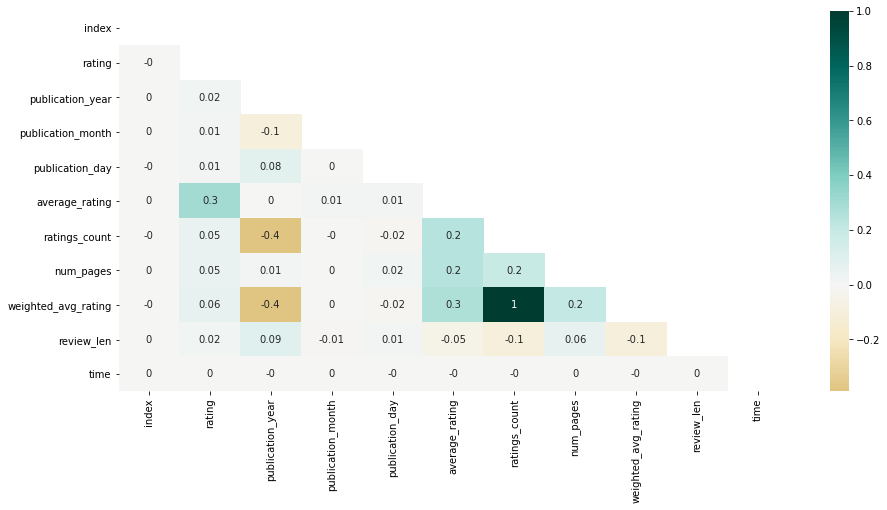

In [94]:
#Heatmap of correlations ()
plt.figure(figsize=(15, 7))
mask = np.triu(train.corr(method = 'spearman'))
sns.heatmap(train.corr(method = 'spearman').round(2), 
            annot = True, 
            fmt='.1g', 
            center= 0, 
            cmap= 'BrBG', 
            mask = mask);

##### (More or less) interesting correlations:
* Older books tend to have more reviews 
* Longer books tend to have more and better ratings
* The review length of books often reviewed tends to be shorter than for less popular books

#### Univariate Distributions

In [21]:
#Isolate numerical data 
num_data = train.select_dtypes(include = 'number')

#Isolate categorical data
cat_data = train.select_dtypes(include = 'object')
cat_data.drop(['spoiler','user_id', 'review', 'review_id', 'description', 'genres', 'review_texts', 'raw_text'], inplace = True, axis = 1)

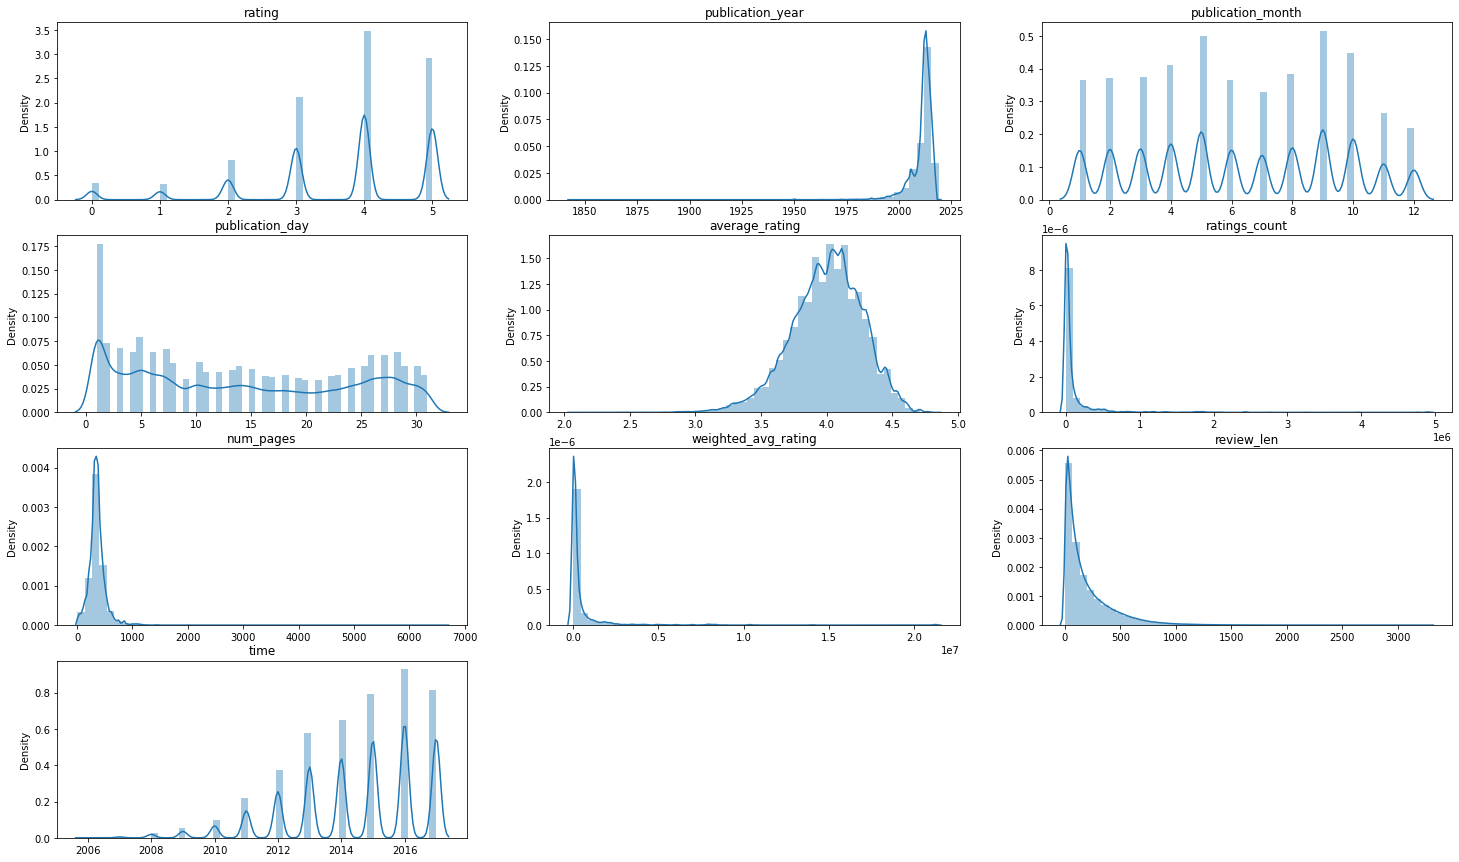

In [97]:
#Distributions of numerical data 
subplot = 1 #index of subplot

#Plot distributions
plt.figure(figsize = (25, 15))
for col in num_data.columns:
    plt.subplot(4, 3,subplot)
    sns.distplot(x = num_data[col]).set(title = list(num_data.columns)[subplot-1])
    subplot += 1

##### Insights
* ratings are left-skewed
* Most books reviews are from the current decade
* Fewer books are published at the end of the year
* Most books are published at the beginning of the month
* average ratings are normally distributed
* number of ratings is right-sqewed, therefore also the weighted average ratings
* Most reviews are short 
* review time is left-skewed

### Are different genres more likely to be spoilered?

First of all, let's have a look at the overall frequency of spoilers in book reviews.

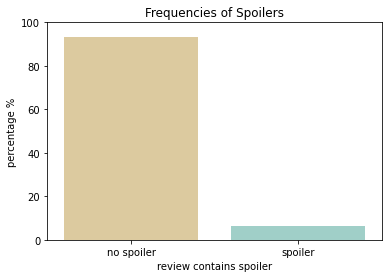

In [76]:
#Get relative frequencies of spoiler and non-spoiler reviews
y = train.spoiler_dum.value_counts()/len(train)*100

#Plot frequencies
sns.barplot(y = [y[0], y[1]], x = ['no spoiler', 'spoiler'], palette = 'BrBG').set(title = 'Frequencies of Spoilers', 
                                                                         xlabel = 'review contains spoiler',
                                                                             ylabel = 'percentage %', 
                                                                                   ylim = (0, 100));
plt.savefig('images/freq_spoilers.png')

Now we have a look at spoiler reviews in the several genres

In [24]:
#Compute frequencies of spoiler and non-spoiler reviews in genres
spoilers = train.groupby('genre').spoiler_dum.value_counts()

#List of genres
genres = list(train.genre.unique())
genres.pop() #pop nan

#Empty lists
genre_values = []
genre_keys = []
genre_dict = {}

In [25]:
#Fetch relative frequency of spoiler reviews for genres and write them in dictionary
for genre in genres:
    rel = (spoilers[genre][1]/ (spoilers[genre][0]+ spoilers[genre][1]))*100
    genre_dict[genre] = rel
    
#Transfer data into ordered dict to be able to sort values
from collections import OrderedDict
sort_genre_dict = OrderedDict(sorted(genre_dict.items(), key = lambda x: x[1]))
genre_values = list(sort_genre_dict.values())[::-1]
genre_keys = list(sort_genre_dict.keys())[::-1]

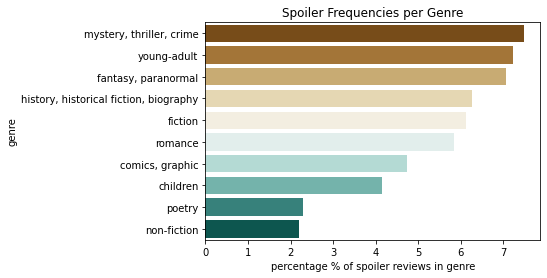

In [77]:
#Plot
sns.barplot(x = genre_values, y = genre_keys, palette = 'BrBG').set(title = 'Spoiler Frequencies per Genre', 
                                                  ylabel = 'genre',xlabel = 'percentage % of spoiler reviews in genre',); 

Top 3 spoiler genres are crime, fantasy, young adult. Let's have a closer look at these three categories. 

##### What's the proportion of top 3 spoiler categories in genres?

In [27]:
#Get proportions 
ycri = (train.query('genre == "mystery, thriller, crime"').genre.value_counts()/len(train))*100
yfan = (train.query('genre =="fantasy, paranormal"').genre.value_counts()/len(train))*100
yyou = (train.query('genre == "young-adult"').genre.value_counts()/len(train))*100
print(ycri)
print(yfan)
print(yyou)

mystery, thriller, crime   5.3793426607064365
Name: genre, dtype: float64
fantasy, paranormal   33.37307280824701
Name: genre, dtype: float64
young-adult   17.486958541015284
Name: genre, dtype: float64


In [28]:
#Cumulative percentages
crim_cum = ycri[0]
you_cum = yyou[0] + crim_cum
fan_cum = you_cum + yfan[0]
other_cum = 100

In [107]:
#Define patches for plot legend
import matplotlib.patches as mpatches
other_patch = mpatches.Patch(color='peru', label='other')
fan_patch = mpatches.Patch(color='tan', label='fantasy')
cri_patch = mpatches.Patch(color='lightcyan', label='young adult')
you_patch = mpatches.Patch(color='darkcyan', label='crime, thriller, mystery')

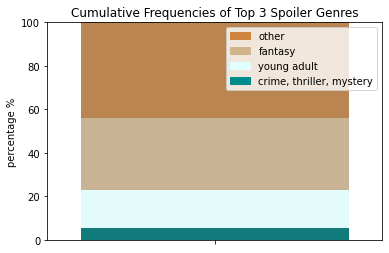

In [108]:
#Build stapled bar plot
plt.figure()
plt.subplot()
sns.barplot(y = [other_cum], x = [''], color = 'peru').set(ylabel = 'percentage %', ylim = (0,100))

plt.subplot()
sns.barplot(y = [fan_cum], x = [''], color = 'tan').set(ylabel = 'percentage %', ylim = (0,100))

plt.subplot()
sns.barplot(y = [you_cum], x = [''], color = 'lightcyan').set(ylabel = 'percentage %', ylim = (0,100))

plt.subplot()
sns.barplot(y = [crim_cum], x = [''], color = 'darkcyan').set(ylabel = 'percentage %', ylim = (0,100))

plt.legend(handles=[other_patch, fan_patch, cri_patch, you_patch])
plt.title('Cumulative Frequencies of Top 3 Spoiler Genres')
plt.savefig('images/top3_spoilers_genre.png')

Although the crime genre is most spoiler-prone, it makes only a small proportion of data as compared with other genres.

### Are different books more likely to be spoilered?

Let's have a look at the Top 15 of titles with reviews containing spoilers. We only consider titles with more than 10 reviews.

In [31]:
#Compute frequencies of spoiler and non-spoiler reviews in titles
spoilers_t = train.groupby('title').spoiler_dum.value_counts()

#List of titles
titles = list(train.title.unique())

#Empty lists
title_values = []
title_keys = []
title_dict = {}

In [32]:
#Fetch relative frequency of spoiler reviews for titles and write them in dictionary
for t in titles:
    try: 
        if ((spoilers_t[t][1] + spoilers_t[t][0]) > 10):
            rel = (spoilers_t[t][1]/ (spoilers_t[t][0]+ spoilers_t[t][1]))*100
            title_dict[t] = rel
        else:
            continue
    except:
        pass
from collections import OrderedDict
sort_title_dict = OrderedDict(sorted(title_dict.items(), key = lambda x: x[1]))
title_values = list(sort_title_dict.values())[::-1]
title_keys = list(sort_title_dict.keys())[::-1]

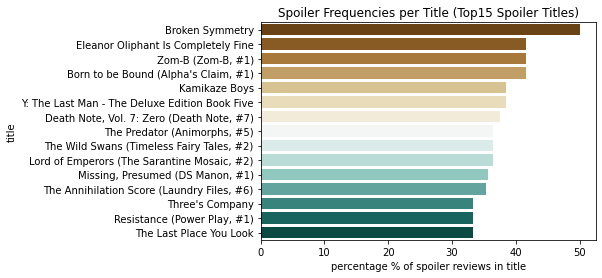

In [78]:
sns.barplot(x = title_values[:15], y = title_keys[:15], palette = 'BrBG').set(title = 'Spoiler Frequencies per Title (Top15 Spoiler Titles)', 
                                                  ylabel = 'title',xlabel = 'percentage % of spoiler reviews in title',); 

In [34]:
#Get absolute frequencies of spoilers and nonspoilers for Top 15 spoiler titles
dict_abs_spoil = {}
dict_abs_nonspoil = {}
for t in title_keys[:15]:
    dict_abs_spoil[t] = spoilers_t[t][1]
    dict_abs_nonspoil[t] = spoilers_t[t][0]

In [35]:
#Get cumulative frequencies 
dict_cum = {}
for t in title_keys[:15]:
    dict_cum[t] = dict_abs_spoil[t] + dict_abs_nonspoil[t]

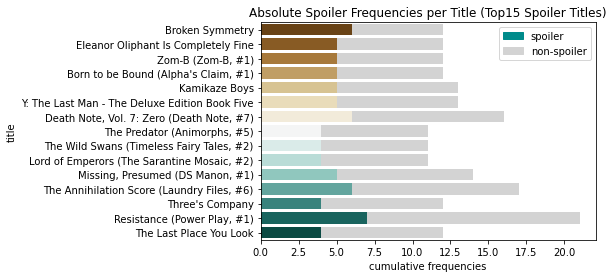

In [109]:
#Plot the cumulative frequencies
sns.barplot(y = list(dict_cum.keys()), x = list(dict_cum.values()), color = 'lightgrey').set(title = 'Absolute Spoiler Frequencies per Title (Top15 Spoiler Titles)', 
                                                  ylabel = 'title',xlabel = 'frequency',); 
sns.barplot(y = list(dict_abs_spoil.keys()), x = list(dict_abs_spoil.values()), palette = 'BrBG').set(title = 'Absolute Spoiler Frequencies per Title (Top15 Spoiler Titles)', 
                                                  ylabel = 'title',xlabel = 'cumulative frequencies',); 

spoil_patch = mpatches.Patch(color = 'darkcyan', label='spoiler')
nonspoil_patch = mpatches.Patch(color='lightgrey', label='non-spoiler')
plt.legend(handles = [spoil_patch, nonspoil_patch]);

The titles with the highest proportion of spoiler reviews have only a small overall number of reviews.

Therefore, let's also have a look at the ten titles with the lowest spoiler proportion - we guess that these books have by far more reviews.

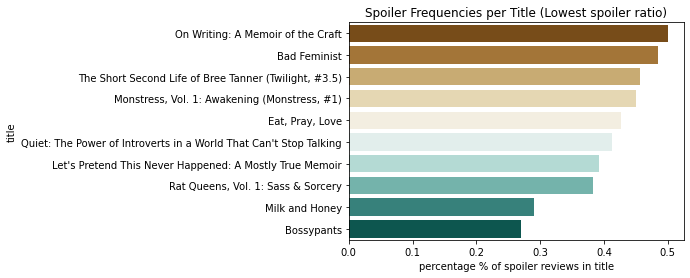

In [145]:
#Get the 10 titles with the lowest proportion of spoilers.
sns.barplot(x = title_values[-10:], y = title_keys[-10:], palette = 'BrBG').set(title = 'Spoiler Frequencies per Title (Lowest spoiler ratio)', 
                                                  ylabel = 'title',xlabel = 'percentage % of spoiler reviews in title',); 

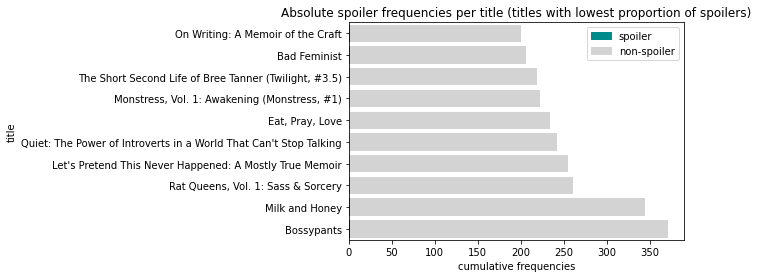

In [111]:
#Get absolute frequencies of spoilers and nonspoilers for the 10 titles with the lowest proportion of spoilers.
dict_abs_spoil_low = {}
dict_abs_nonspoil_low = {}
for t in title_keys[-10:]:
    dict_abs_spoil_low[t] = spoilers_t[t][1]
    dict_abs_nonspoil_low[t] = spoilers_t[t][0]
    
#Get cumulative frequencies 
dict_cum_low = {}
for t in title_keys[-10:]:
    dict_cum_low[t] = dict_abs_spoil_low[t] + dict_abs_nonspoil_low[t]
    
#Plot the cumulative frequencies
sns.barplot(y = list(dict_cum_low.keys()), x = list(dict_cum_low.values()), color = 'lightgrey').set(title = 'Absolute Spoiler Frequencies per Title (Titles with lowest proportion of spoilers)', 
                                                  ylabel = 'title',xlabel = 'frequency',); 
sns.barplot(y = list(dict_abs_spoil_low.keys()), x = list(dict_abs_spoil_low.values()), palette = 'BrBG').set(title = 'Absolute spoiler frequencies per title (titles with lowest proportion of spoilers)', 
                                                  ylabel = 'title',xlabel = 'cumulative frequencies',); 

spoil_patch = mpatches.Patch(color = 'darkcyan', label='spoiler')
nonspoil_patch = mpatches.Patch(color='lightgrey', label='non-spoiler')
plt.legend(handles = [spoil_patch, nonspoil_patch]);

Well, the ten books with the lowest proportion of spoilers indeed have more reviews - but not *that* much more. 

#### What genres do the Top15 spoiler titles come from?

In [39]:
# Top 10 spoiler titles
top15 = list(dict_abs_spoil.keys())

In [40]:
#Reset index
train.reset_index(inplace = True)

In [41]:
# Get the genres of Top15 spoiler titles
title_dict = {}
for i in range(len(train)):
    if train.title[i] in top15:
        if train.title[i] not in title_dict:
            title_dict[train.title[i]] = train.genre[i]

In [42]:
#Get genre counts
genre_counts = {}

for value in title_dict.values():
    if value not in genre_counts:
        genre_counts[value] = 1
    else:
        genre_counts[value] +=1
sort_genre_counts = OrderedDict(sorted(genre_counts.items(), key = lambda x: x[1]))
sort_genre_counts

OrderedDict([('comics, graphic', 2),
             ('young-adult', 2),
             ('mystery, thriller, crime', 2),
             ('fiction', 2),
             ('romance', 3),
             ('fantasy, paranormal', 4)])

In [43]:
# Cumulative frequencies
val_com = sort_genre_counts['comics, graphic']
val_you = val_com + sort_genre_counts['young-adult']
val_cri = val_you + sort_genre_counts['mystery, thriller, crime']
val_fic = val_cri + sort_genre_counts['fiction']
val_rom = val_fic + sort_genre_counts['romance']
val_fan = 15

In [121]:
#Patches for plot legend
patch1 = mpatches.Patch(color='lightcyan', label='comics')
patch2 = mpatches.Patch(color='mediumaquamarine', label='young adult')
patch3 = mpatches.Patch(color='darkcyan', label='crime')
patch4 = mpatches.Patch(color='beige', label='fiction')
patch5 = mpatches.Patch(color='tan', label='romance')
patch6 = mpatches.Patch(color='peru', label='fantasy')

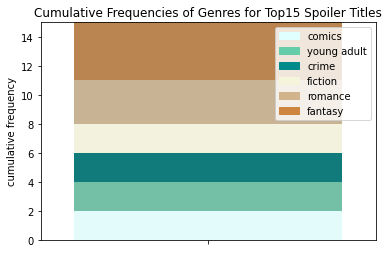

In [122]:
plt.figure()
plt.subplot()
sns.barplot(y = [val_fan], x = [''], color = 'peru').set(ylabel = 'cumulative frequency', ylim = (0,15))

plt.subplot()
sns.barplot(y = [val_rom], x = [''], color = 'tan').set(ylabel = 'cumulative frequency', ylim = (0,15))

plt.subplot()
sns.barplot(y = [val_fic], x = [''], color = 'beige').set(ylabel = 'cumulative frequency', ylim = (0,15))

plt.subplot()
sns.barplot(y = [val_cri], x = [''], color = 'darkcyan').set(ylabel = 'cumulative frequency', ylim = (0,15))

plt.subplot()
sns.barplot(y = [val_you], x = [''], color = 'mediumaquamarine').set(ylabel = 'cumulative frequency', ylim = (0,15))

plt.subplot()
sns.barplot(y = [val_com], x = [''], color = 'lightcyan').set(ylabel = 'cumulative frequency', ylim = (0,15))
plt.legend(handles = [patch1, patch2,patch3,patch4,patch5,patch6])

plt.title('Cumulative Frequencies of Genres for Top15 Spoiler Titles')
plt.savefig('images/genres_t15_titles.png')

### Are different reviewers more likely to write spoilers?

In [46]:
#Average spoilers per user
avg_spoilers = train.query('spoiler_dum == "spoiler"').spoiler_dum.value_counts()[0]/ train.user_id.nunique()
print('Average spoilers per user: ', round(avg_spoilers, 2))

Average spoilers per user:  3.35


In [47]:
#Get the Top10 spoiler reviewers
users_spoiler = train.query('spoiler_dum == "spoiler"').groupby('user_id').spoiler_dum.value_counts()
users_spoiler = users_spoiler.sort_values(ascending = False)[:10]

In [48]:
#Get a list of the Top10 user ids
top10_ids = [ i for i, j in users_spoiler.index]

In [49]:
#Calculate the total number of reviews by the Top10 spoiler users
total_reviews = []
for i in top10_ids:
    total_reviews.append(train.user_id.value_counts()[i])

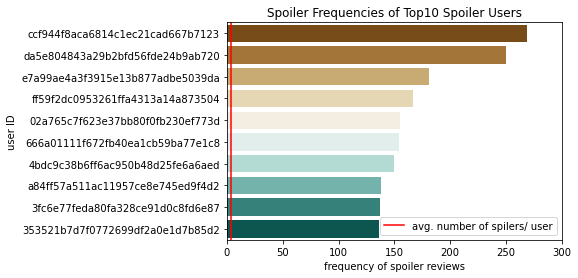

In [81]:
plt.figure()
sns.barplot(x = users_spoiler, y = top10_ids, palette = 'BrBG').set(title = 'Spoiler Frequencies of Top10 Spoiler Users', 
                                                  ylabel = 'user ID',xlabel = 'frequency of spoiler reviews', 
                                                  xlim = (0, 300));
plt.axvline(x = avg_spoilers, ls='-', c='red', label = 'avg. number of spilers/ user')
plt.legend()
plt.savefig('images/freq_spoilers_users.png')

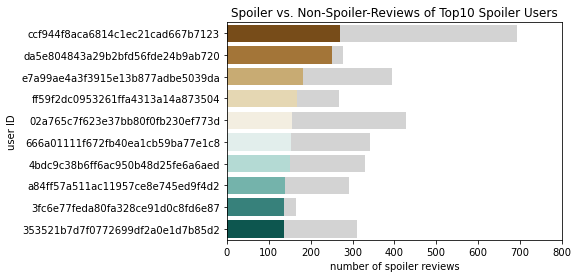

In [82]:
plt.figure()
sns.barplot(x = total_reviews, y = top10_ids, color = 'lightgrey').set(ylabel = 'user ID',xlabel = 'number of spoiler reviews', xlim = (0, 800));
                                                                                    
sns.barplot(x = users_spoiler, y = top10_ids, palette = 'BrBG').set(ylabel = 'user ID',xlabel = 'number of spoiler reviews', 
                                                  xlim = (0, 800));
plt.title('Spoiler vs. Non-Spoiler-Reviews of Top10 Spoiler Users')
plt.savefig('images/freq_spoilers_users.png')

Let's see the Top10 Spoiler users based on relative frequencies of spoiler reviews. Only reviewers with more than 10 reviews are taken into account.

In [52]:
#Compute frequencies of spoiler and non-spoiler reviews per user
spoilers_u = train.groupby('user_id').spoiler_dum.value_counts()

#List of user IDs
users = list(train.user_id.unique())
#titles.pop() #pop nan

#Empty lists
user_values = []
user_keys = []
user_dict = {}

In [53]:
#Fetch relative frequency of spoiler reviews for users and write them in dictionary
for u in tqdm(users):
    try:
        if ((spoilers_u[u][1] + spoilers_u[u][0]) > 10):
            rel = (spoilers_u[u][1]/ (spoilers_u[u][0]+ spoilers_u[u][1]))*100
            user_dict[u] = rel
        else:
            continue
    except:
        pass

sort_user_dict = OrderedDict(sorted(user_dict.items(), key = lambda x: x[1]))
user_values = list(sort_user_dict.values())[::-1]
user_keys = list(sort_user_dict.keys())[::-1]

100%|██████████| 18734/18734 [00:40<00:00, 460.65it/s] 


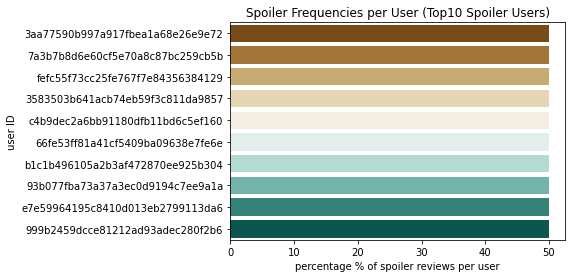

In [123]:
sns.barplot(x = user_values[:10], y = user_keys[:10], palette = 'BrBG').set(title = 'Spoiler Frequencies per User (Top10 Spoiler Users)', 
                                                  ylabel = 'user ID',xlabel = 'percentage % of spoiler reviews per user',); 

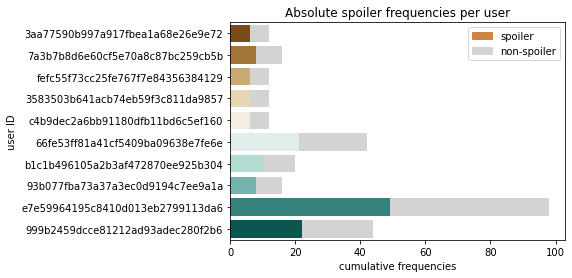

In [89]:
#Get absolute frequencies of spoilers and nonspoilers for the 10 users with the highest proportion of spoilers.
dict_user_spoil = {}
dict_user_nonspoil = {}
for u in user_keys[:10]:
    dict_user_spoil[u] = spoilers_u[u][1]
    dict_user_nonspoil[u] = spoilers_u[u][0]
    
#Get cumulative frequencies 
dict_cum_user = {}
for u in user_keys[:10]:
    dict_cum_user[u] = dict_user_spoil[u] + dict_user_nonspoil[u]
    
#Plot the cumulative frequencies
sns.barplot(y = list(dict_cum_user.keys()), x = list(dict_cum_user.values()), color = 'lightgrey').set(title = 'Absolute Spoiler Frequencies per user', 
                                                  ylabel = 'user ID',xlabel = 'frequency',); 
sns.barplot(y = list(dict_user_spoil.keys()), x = list(dict_user_spoil.values()), palette = 'BrBG').set(title = 'Absolute spoiler frequencies per user', 
                                                  ylabel = 'user ID',xlabel = 'cumulative frequencies',); 

spoil_patch = mpatches.Patch(color = 'peru', label='spoiler')
nonspoil_patch = mpatches.Patch(color='lightgrey', label='non-spoiler')
plt.legend(handles = [spoil_patch, nonspoil_patch]);

#### In which genres do the Top10 spoiler users write their reviews?

We calculate this for the ten users with the highest spoiler _ratio_, not the users with the highest absolute number of spoiler reviews.

In [56]:
user_genre = {}
#train.reset_index()
#Get the genres and according frequencies
for i in tqdm(range(len(train))):
    if train.spoiler_dum[i] == "no spoiler":
        continue
    else:
        if train.user_id[i] in user_keys[:10]:
            if train.genre[i] not in user_genre:
                user_genre[train.genre[i]] = 1
            else: 
                user_genre[train.genre[i]] += 1
        else:
            continue
sorted_user_genre = OrderedDict(sorted(user_genre.items(), key = lambda x: x[1]))

100%|██████████| 964616/964616 [00:25<00:00, 37804.19it/s]


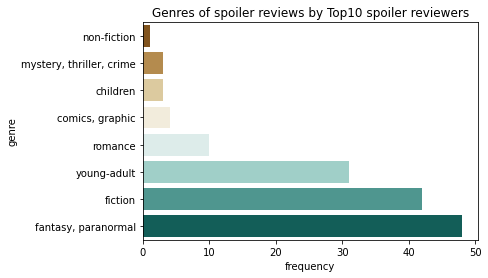

In [90]:
sns.barplot(y = list(sorted_user_genre.keys()), x = list(sorted_user_genre.values()), palette = 'BrBG').set(xlabel = 'frequency', 
                                                                                              ylabel = 'genre')
plt.title('Genres of spoiler reviews by Top10 spoiler reviewers');

### Number of reviews and spoilers over time

In [58]:
time_rev = train.time.value_counts()
time_spoilers = train.query("spoiler_dum == 'spoiler'").groupby('time').spoiler_dum.value_counts()

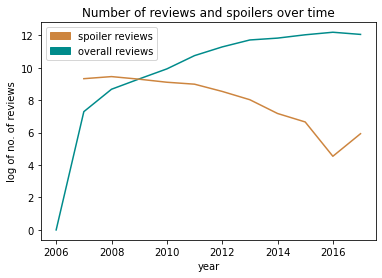

In [93]:
spoi_patch = mpatches.Patch(color='peru', label='spoiler reviews')
rev_patch = mpatches.Patch(color='darkcyan', label='overall reviews')

plt.figure()
sns.lineplot(y = np.log(time_rev), x = [2016, 2017, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006],  color = 'darkcyan').set(title = 'Number of reviews over time', 
                                                                         xlabel = 'year',
                                                                         ylabel = 'log of no. of reviews'); 
sns.lineplot(y = np.log(time_spoilers), x = [2016, 2017, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007],  color = 'peru').set(title = 'Number of reviews and spoilers over time', 
                                                                         xlabel = 'year',
                                                                         ylabel = 'log of no. of reviews'); 
plt.legend(handles = [spoi_patch, rev_patch]);

### What's the ratio of spoiler text/total review text in reviews?

In [60]:
#Sentence-wise calculation of the spoiler/ non-spoiler ratio, provided the review contains a spoiler
#Empty list
spoil_ratio = []

# Auxiliary variable
a = 0

#Get ratio
for i in tqdm(train['index']):
    try: #Calculate number of spoiler sentences in review/ total number of sentences
        a = (sum(train.sentence_labels[i]))/(len(train.sentence_labels[i]))
        if a != 0: #Only if the review contains a spoiler, add the ratio to the list
            spoil_ratio.append(a)
    except:
        pass

100%|██████████| 964616/964616 [00:30<00:00, 31364.24it/s]


In [61]:
#Average ratio of spoiler sentences/ non-spoiler sentences
avg_ratio = sum(spoil_ratio)/len(spoil_ratio)
print('Average ratio of spoiler sentences/ non-spoiler sentences: ', round(avg_ratio, 2))

Average ratio of spoiler sentences/ non-spoiler sentences:  0.28


In [62]:
#Plot distribution of spoiler/ non-spoiler ratios
sp_ratio = pd.DataFrame(spoil_ratio, columns = ['ratio'])

In [63]:
#Bin the ratios for more clarity in the plot
ratio_bins = np.arange(0, 1.1, .1) #10 bins with 0.1-steps from 0 to 1
binned_ratios = pd.cut(sp_ratio['ratio'], bins = ratio_bins)

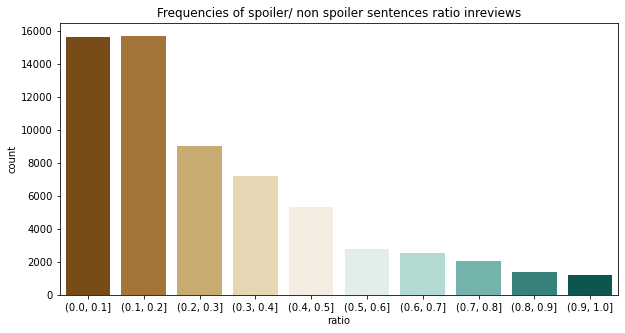

In [124]:
plt.figure(figsize = (10, 5))
sns.countplot(x = binned_ratios, palette = 'BrBG').set(title = '''Frequencies of spoiler/ non spoiler sentences ratio in reviews''');

### At which positions are spoilers in the review?

In [65]:
# Calculate the number of sentences per review and the position (= number of sentence) of the first spoiler and write them
# in a dictionary.
dict = {}
spoiler_pos = {}
for i in tqdm(train['index']):
    try:
        dict[i] = [len(train.sentence_labels[i]), train.sentence_labels[i].index(1)]
       
    except:
        pass
    
#Tranfer the dicitionary into a dataframe:
df_rev = pd.DataFrame.from_dict(dict).T #transpose
df_rev.rename(columns={0:'review_length', 1:'spoiler_pos'}, inplace = True) #rename columns
df_rev.reset_index(inplace = True) #reset index

100%|██████████| 964616/964616 [00:30<00:00, 31498.25it/s]


In [ ]:
#pd.Series with review lengths 

In [137]:
#Average number of sentences in a non-spoiler review

dict_non = {}
for i in tqdm(train['index']):
    try:
        if train.spoiler_dum[i] == 'no spoiler':
            dict_non[i] = len(train.sentence_labels[i])
        else:
            continue
    except:
        pass

avg_rev_length_non = sum(dict_non.values()) / len(dict_non) 
print('Average number of sentences in a non-spoiler review: ', round(avg_rev_length_non, 2))

100%|██████████| 964616/964616 [00:24<00:00, 39937.00it/s]

Average number of sentences in a non-spoiler review:  12.06


In [138]:
#Average number of sentences in a spoiler review:
avg_rev_length = df_rev.review_length.mean()
print('Average number of sentences in a spoiler review: ', round(avg_rev_length, 2))

Average number of sentences in a spoiler review:  23.82


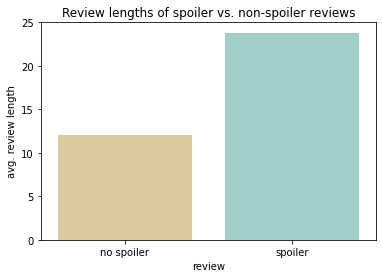

In [144]:
sns.barplot(y = [avg_rev_length_non, avg_rev_length], x = ['no spoiler', 'spoiler'], palette = 'BrBG').set(title = 'Review lengths of spoiler vs. non-spoiler reviews', xlabel = 'review', ylabel = 'avg. review length');

In [67]:
#Average position of the first spoiler sentence:
avg_spoiler_pos = df_rev.spoiler_pos.mean()
print('Average position of the first spoiler sentence: ', round(avg_spoiler_pos, 2))

Average position of the first spoiler sentence:  10.92


--> Spoilers beginn in the middle of a review.

Let's plot the frequencies of spoiler located at the beginning, middle, or end of a review. Beginning/ middle and end are cosnidered as positions in the first, second and third third of the review.

In [68]:
#new column with ratio of spoiler position and review length.
df_rev['ratio'] = round(df_rev.spoiler_pos/df_rev.review_length, 2)

In [69]:
#new, empty column of spoiler position
df_rev['spoiler_position'] = pd.Series()

In [70]:
# Fill the new column
df_rev.loc[df_rev.ratio <= 0.67, 'spoiler_position'] = 'middle'
df_rev.loc[df_rev.ratio > 0.67, 'spoiler_position'] = 'end'
df_rev.loc[df_rev.ratio <= 0.33, 'spoiler_position'] = 'beginning'

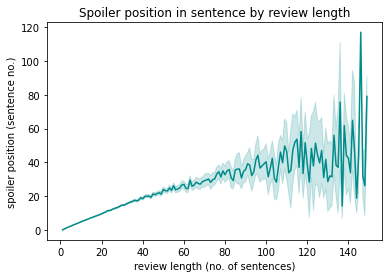

In [125]:
#Plot spoiler position by review length
sns.lineplot(x = df_rev.review_length, y = df_rev.spoiler_pos, color = 'darkcyan').set(ylabel = 'spoiler position (sentence no.)', 
                                                                            xlabel = 'review length (no. of sentences)', 
                                                                            title = 'Spoiler position in sentence by review length');

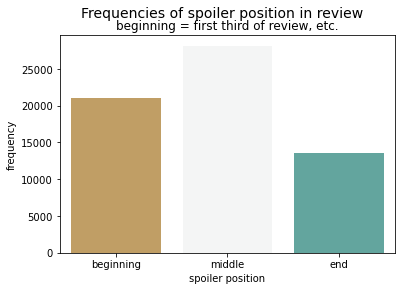

In [126]:
#Plot frequency distribution of spoiler position
sns.countplot(x = df_rev.spoiler_position, palette = 'BrBG', order = ['beginning', 'middle', 'end']).set(xlabel = 'spoiler position',
                                                                                                          ylabel = 'frequency',
                                                                                                          title = 'beginning = first third of review, etc.')
plt.suptitle('Frequencies of spoiler position in review', fontsize =14);

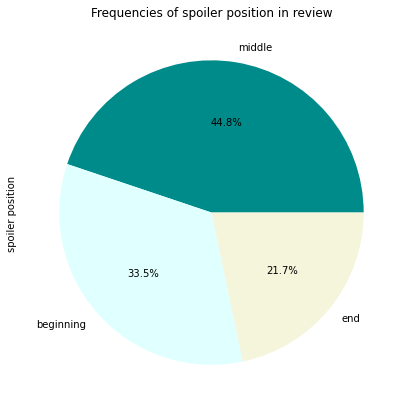

In [127]:
#Another graph with the same information
plt.figure(figsize = (7, 7))
df_rev.spoiler_position.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', colors = ['darkcyan', 'lightcyan', 'beige']).set(ylabel = 'spoiler position', title = 'Frequencies of spoiler position in review'); 
plt.savefig('spoiler_position.png')